In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,explode,array
from pyspark.sql.types import *
import pyspark.pandas as pd
import numpy as np
from sklearn.cluster import KMeans as km
from sklearn.cluster import DBSCAN
from pyspark.ml.clustering import BisectingKMeans, KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [56]:
# prevent binary value and turn them to string, change how spark do partition
spark.conf.set("spark.sql.parquet.binaryAsString","true")
spark.conf.set("spark.sql.adaptive.enabled",True)

In [78]:
# However, even write the parquet to HDFS with certain partition, read in partition will be limit to 2 or 3
# see https://stackoverflow.com/questions/50825835/does-spark-maintain-parquet-partitioning-on-read
sc.defaultParallelism

2

In [14]:
# load cleaned parquet
load_df1 = spark.read.parquet('/combined_filtered_parquet_bycity')
load_df2 = spark.read.parquet('/combined_filtered_parquet_random')

<h3>Part.1 KMeans Cluster for Cities and Performance Comparison<h3>


In [63]:
load_df_bycity = load_df1 
load_df_random = load_df2
load_df_evenly = load_df2

In [58]:
# As partition being limit to 2, it also caused data skew
print("paris: ", load_df_bycity.rdd.getNumPartitions()) 
print("paris: ", load_df_random.rdd.getNumPartitions()) 
load_df_bycity.groupBy(F.spark_partition_id()).count().show()
load_df_random.groupBy(F.spark_partition_id()).count().show()

paris:  2
paris:  2
+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                   0| 1986|
|                   1|  133|
+--------------------+-----+

+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                   0| 1986|
|                   1|  133|
+--------------------+-----+



In [82]:
# change the partition of load_df_bycity to fix data skewness in partition
# 1636 is sum of paris + london = 1120 + 516, 483 is sum of toronto + rome = 281 + 202
# need to reload the partition since repartition will store on memory
load_df_bycity = load_df_bycity.repartition(4, 'City')
load_df_bycity.write.partitionBy("City").mode("overwrite").parquet("/load_df_bycity")
load_df_bycity = spark.read.parquet('/load_df_bycity')
load_df_bycity.groupBy(F.spark_partition_id()).count().show()
load_df_evenly = load_df_evenly.repartition(1)
load_df_evenly.groupBy(F.spark_partition_id()).count().show()

+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                   0| 1636|
|                   1|  483|
+--------------------+-----+

+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                   0| 2119|
+--------------------+-----+



In [83]:
# load dataframe with different partition and see how they perform, turn them into vector features
df1 = load_df_evenly

assembler1 = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
data_df1 = assembler1.transform(df1)

In [84]:
df2 = load_df_random

assembler2 = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
data_df2 = assembler2.transform(df2)

In [85]:
df3 = load_df_bycity

assembler3 = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
data_df3 = assembler3.transform(df3)

In [86]:
%%time
# Define the K-means clustering model, loaded with one partition
dataDF1=data_df1
kmeans1 = KMeans(k=180, featuresCol="features", predictionCol="k_cluster", seed=1000, initMode='k-means||')
kmeans_model1 = kmeans1.fit(dataDF1)

# Assigning the data points to clusters
clustered_data1 = kmeans_model1.transform(dataDF1)

CPU times: user 5.32 ms, sys: 5.72 ms, total: 11 ms
Wall time: 1.45 s


In [87]:
%%time
# loaded with system assigned partition
dataDF2=data_df2
kmeans2 = KMeans(k=180, featuresCol="features", predictionCol="k_cluster", seed=1000, initMode='k-means||')
kmeans_model2 = kmeans2.fit(dataDF2)

# Assigning the data points to clusters
clustered_data2 = kmeans_model2.transform(dataDF2)

CPU times: user 10.1 ms, sys: 4.61 ms, total: 14.7 ms
Wall time: 1.57 s


In [88]:
%%time
# loaded with partition by city
dataDF3=data_df3
kmeans3 = KMeans(k=180, featuresCol="features", predictionCol="k_cluster", seed=1000, initMode='k-means||')
kmeans_model3 = kmeans3.fit(dataDF3)

# Assigning the data points to clusters
clustered_data3 = kmeans_model3.transform(dataDF3)

CPU times: user 8.82 ms, sys: 4.13 ms, total: 12.9 ms
Wall time: 1.66 s


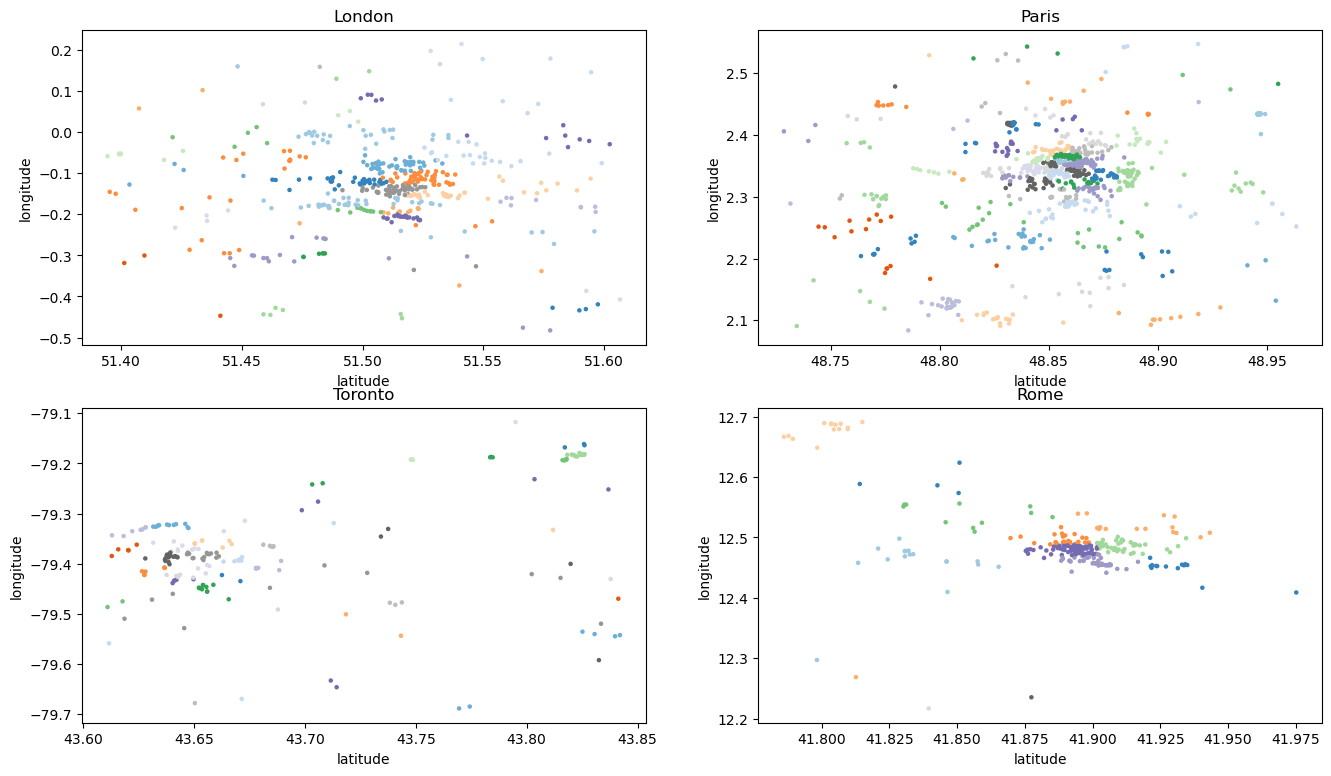

In [147]:
# plot the first round KMeans cluster result
clustered_data_pd1 = clustered_data1.filter(clustered_data1['City'] == 'london').toPandas()
clustered_data_pd2 = clustered_data1.filter(clustered_data1['City'] == 'paris').toPandas()
clustered_data_pd3 = clustered_data1.filter(clustered_data1['City'] == 'toronto').toPandas()
clustered_data_pd4 = clustered_data1.filter(clustered_data1['City'] == 'rome').toPandas()

# Visualizing the results
fig, axs = plt.subplots(2, 2, figsize=[16, 9])
axs[0, 0].scatter(clustered_data_pd1["latitude"], clustered_data_pd1["longitude"], c=clustered_data_pd1["k_cluster"], cmap='tab20c', s=5)
axs[0, 0].set_title('London')
axs[0, 1].scatter(clustered_data_pd2["latitude"], clustered_data_pd2["longitude"], c=clustered_data_pd2["k_cluster"], cmap='tab20c', s=5)
axs[0, 1].set_title('Paris')
axs[1, 0].scatter(clustered_data_pd3["latitude"], clustered_data_pd3["longitude"], c=clustered_data_pd3["k_cluster"], cmap='tab20c', s=5)
axs[1, 0].set_title('Toronto')
axs[1, 1].scatter(clustered_data_pd4["latitude"], clustered_data_pd4["longitude"], c=clustered_data_pd4["k_cluster"], cmap='tab20c', s=5)
axs[1, 1].set_title('Rome')

for ax in axs.flat:
    ax.set(xlabel='latitude', ylabel='longitude')

plt.show()

In [94]:
# Compares the sklearn kmeans and pyspark kmeans performance
def dbscan_kmeans1(coords):
    result = [[0, [1.0], [1.0]], [2, [1.0], [1.0]], [3, [1.0], [1.0]]]
    coords_np = np.array(coords)        
    kmeans = km(n_clusters=180, n_init=2, random_state=1000)
    kmm = kmeans.fit(coords_np)
    center = kmm.cluster_centers_
    return result

In [95]:
# schema for sklearn kmeans
schema_dbs1 = StructType([
    StructField("clusterid", IntegerType(), False),
    StructField("latitude", FloatType(), False),
    StructField("longitude", FloatType(), False)
])
udf_dbscan1 = F.udf(lambda x: dbscan_kmeans1(x), schema_dbs1)

In [104]:
# modify df for sklearn kmeans udf
data_df_city = load_df_bycity
data_df_city = data_df_city.withColumn('point', array(col('latitude'),col('longitude'))) \
                .groupBy('city').agg(F.collect_list('point').alias('point_list'))
data_df_city.show()

+-------+--------------------+
|   city|          point_list|
+-------+--------------------+
|  paris|[[48.9434728, 2.3...|
| london|[[51.3952047, -0....|
|toronto|[[43.684182, -79....|
|   rome|[[41.9025331, 12....|
+-------+--------------------+



In [105]:
%%time
# show how sklearn kmeans perform
data_df_city = data_df_city.withColumn('cluster', udf_dbscan1(col('point_list')))
data_df_city.show()

+-------+--------------------+-------------+
|   city|          point_list|      cluster|
+-------+--------------------+-------------+
|  paris|[[48.9434728, 2.3...|{0, 0.0, 0.0}|
| london|[[51.3952047, -0....|{0, 0.0, 0.0}|
|toronto|[[43.684182, -79....|{0, 0.0, 0.0}|
|   rome|[[41.9025331, 12....|{0, 0.0, 0.0}|
+-------+--------------------+-------------+

CPU times: user 0 ns, sys: 2.82 ms, total: 2.82 ms
Wall time: 803 ms


<h3>Part.2 Combine with DBSCAN to futher reduce noise in tourism spot<h3>


In [212]:
# go over each tourism spot clusters, using DESCAN to clean noise from each cluster
# then use KMeans again for cluster to find out the new center location after noise cleanning.
def dbscan_x(coords):
    kms_per_radian = 6371.0086
    # each cluster must has at least has 3 tourism spot within 3000 meter radius connected
    epsilon = 3 / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=3, algorithm='auto', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels) - set([-1]))
    
    result = []
    coords_np = np.array(coords)
    # use sklearn kmeans as it is faster compares to pyspark kmeans in small scale data
    kmeans = km(n_clusters=1, n_init=1, max_iter=10, random_state=7)

    for n in range(num_clusters):
        # get center of Cluster 'n'
        mask = cluster_labels == n
        one_cluster = coords_np[mask]
        kmm = kmeans.fit(one_cluster.astype(float))
        center = kmm.cluster_centers_
        latlng = center[0].tolist()
        list_c = one_cluster.tolist()
        result.append([n, latlng[0], latlng[1], list_c])
    noise = coords_np[cluster_labels == -1]
    result.append([-1, None, None, noise.tolist()])
    return result

In [213]:
# for nested return array
schema_dbs = ArrayType(StructType([
    StructField("clusterid", IntegerType(), False),
    StructField("latitude", FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("cluster_point", ArrayType(StructType([
        StructField("point_lat", FloatType(), False),
        StructField("point_lon", FloatType(), False)])), False)
]))

In [214]:
udf_dbscan = F.udf(lambda x: dbscan_x(x), schema_dbs)

In [215]:
%%time
# get tourism spot center by each Kmeans cluster of each city from first round KMeans
# choose partition by city df as prepare for larger scale df might help
# k_cluster is cluster label from first round kmeans
data_df = clustered_data3
data_df = data_df.withColumn('point', F.array(F.col('latitude'),F.col('longitude')) ) \
                .groupBy('k_cluster', 'city').agg(F.collect_list('point').alias('point_list')) \
                .withColumn('cluster', udf_dbscan(F.col('point_list')))
data_df.show()

+---------+-----+--------------------+--------------------+
|k_cluster| city|          point_list|             cluster|
+---------+-----+--------------------+--------------------+
|       44|paris|[[48.9434728, 2.3...|[{0, 48.939426, 2...|
|       36|paris|[[48.853273300000...|[{0, 48.846798, 2...|
|       53|paris|[[48.8818908, 2.3...|[{0, 48.885242, 2...|
|       73|paris|[[48.8522072, 2.4...|[{0, 48.853848, 2...|
|      135|paris|[[48.887108600000...|[{0, 48.89374, 2....|
|       85|paris|[[48.863080200000...|[{0, 48.870632, 2...|
|      155|paris|[[48.877367400000...|[{0, 48.87516, 2....|
|      112|paris|[[48.8592237, 2.3...|[{0, 48.86289, 2....|
|       91|paris|[[48.8254595, 2.2...|[{0, 48.81694, 2....|
|      154|paris|[[48.8586455, 2.3...|[{0, 48.860165, 2...|
|      129|paris|[[48.7964877, 2.1...|[{0, 48.800587, 2...|
|       82|paris|[[48.8638253, 2.3...|[{0, 48.859295, 2...|
|       83|paris|[[48.831645, 2.33...|[{0, 48.831696, 2...|
|       12|paris|[[48.857964800000...|[{

In [228]:
%%time
# explode the nested array to get the cluster location, cluster id is given by DBSCAN
# k_cluster is given by first round Kmeans
result_df_center = data_df.withColumn('centers', F.explode('cluster')) \
                .select('city', 'k_cluster', F.col('centers').getItem('latitude').alias('lat'),
                        F.col('centers').getItem('longitude').alias('lon'), 
                        F.col('centers').getItem('clusterid').alias('clusterid'),
                        F.col('centers').getItem('cluster_point').alias('cluster_point'),
                    )

result_df_center.show()
n = result_df_center.count() - 1
print("total center", n)

+-------+---------+---------+----------+---------+--------------------+
|   city|k_cluster|      lat|       lon|clusterid|       cluster_point|
+-------+---------+---------+----------+---------+--------------------+
|toronto|       19|43.829777| -79.53177|        0|[{43.83353, -79.5...|
|toronto|       19|     null|      null|       -1|                  []|
|toronto|       35| 43.65421| -79.45089|        0|[{43.665607, -79....|
|toronto|       35|     null|      null|       -1|                  []|
|toronto|      136| 43.63335| -79.32548|        0|[{43.625877, -79....|
|toronto|      136|     null|      null|       -1|                  []|
|toronto|       24|43.617744| -79.34099|        0|[{43.612953, -79....|
|toronto|       24|     null|      null|       -1|                  []|
|toronto|       55|43.668736| -79.39484|        0|[{43.671616, -79....|
|toronto|       55|     null|      null|       -1|                  []|
|toronto|      148| 43.63885| -79.38536|        0|[{43.64151, -7

total center 322
CPU times: user 49.5 ms, sys: 26.8 ms, total: 76.3 ms
Wall time: 14.2 s


In [229]:
# mark the noise cluster and filter empty cluster
result_df_center = result_df_center.filter(F.size('cluster_point') > 0) \
                                    .withColumn('new_cluster_id', F.when(result_df_center['clusterid'] == -1, -1).otherwise(result_df_center['k_cluster']))
result_df_center.show()

+-------+---------+---------+----------+---------+--------------------+--------------+
|   city|k_cluster|      lat|       lon|clusterid|       cluster_point|new_cluster_id|
+-------+---------+---------+----------+---------+--------------------+--------------+
|toronto|       19|43.829777| -79.53177|        0|[{43.83353, -79.5...|            19|
|toronto|       35| 43.65421| -79.45089|        0|[{43.665607, -79....|            35|
|toronto|      136| 43.63335| -79.32548|        0|[{43.625877, -79....|           136|
|toronto|       24|43.617744| -79.34099|        0|[{43.612953, -79....|            24|
|toronto|       55|43.668736| -79.39484|        0|[{43.671616, -79....|            55|
|toronto|      148| 43.63885| -79.38536|        0|[{43.64151, -79.3...|           148|
|toronto|       86|     null|      null|       -1|[{43.703247, -79....|            -1|
|toronto|       45|43.654034| -79.38371|        0|[{43.65671, -79.3...|            45|
|toronto|      167|     null|      null|   

In [230]:
# explode the nested array, and get the location from each cluster
result_df_cluster = result_df_center.withColumn('points', F.explode('cluster_point')) \
                .select('city', 'new_cluster_id', F.col('points').getItem('point_lat').alias('lat'),
                        F.col('points').getItem('point_lon').alias('lon')
                        )
result_df_cluster.show()

+-----+--------------+---------+---------+
| city|new_cluster_id|      lat|      lon|
+-----+--------------+---------+---------+
|paris|            44|48.943474|2.3207552|
|paris|            44|48.935886|2.3392062|
|paris|            44|48.938026| 2.308187|
|paris|            44|48.940342|2.3215523|
|paris|            44|48.942616|2.3229902|
|paris|            44| 48.93394| 2.310181|
|paris|            44|48.935154|2.3180935|
|paris|            44|48.937065|2.3133185|
|paris|            44|48.948345|2.3070998|
|paris|            36| 48.85327|2.3457322|
|paris|            36|48.838127|2.3456967|
|paris|            36|48.840103|2.3501828|
|paris|            36|48.853237|2.3470464|
|paris|            36|48.838963| 2.349994|
|paris|            36|48.841003| 2.350596|
|paris|            36|48.848286|2.3466358|
|paris|            36|48.843884| 2.341953|
|paris|            36| 48.83969|2.3467534|
|paris|            36|48.841866|2.3430912|
|paris|            36|48.850555|2.3497057|
+-----+----

In [231]:
# plot the first round KMeans cluster result
center_data_pd1 = result_df_center.filter(result_df_center['City'] == 'london').toPandas()
center_data_pd2 = result_df_center.filter(result_df_center['City'] == 'paris').toPandas()
center_data_pd3 = result_df_center.filter(result_df_center['City'] == 'toronto').toPandas()
center_data_pd4 = result_df_center.filter(result_df_center['City'] == 'rome').toPandas()
final_clustered_data_pd1 = result_df_cluster.filter(result_df_cluster['City'] == 'london').toPandas()
final_clustered_data_pd2 = result_df_cluster.filter(result_df_cluster['City'] == 'paris').toPandas()
final_clustered_data_pd3 = result_df_cluster.filter(result_df_cluster['City'] == 'toronto').toPandas()
final_clustered_data_pd4 = result_df_cluster.filter(result_df_cluster['City'] == 'rome').toPandas()

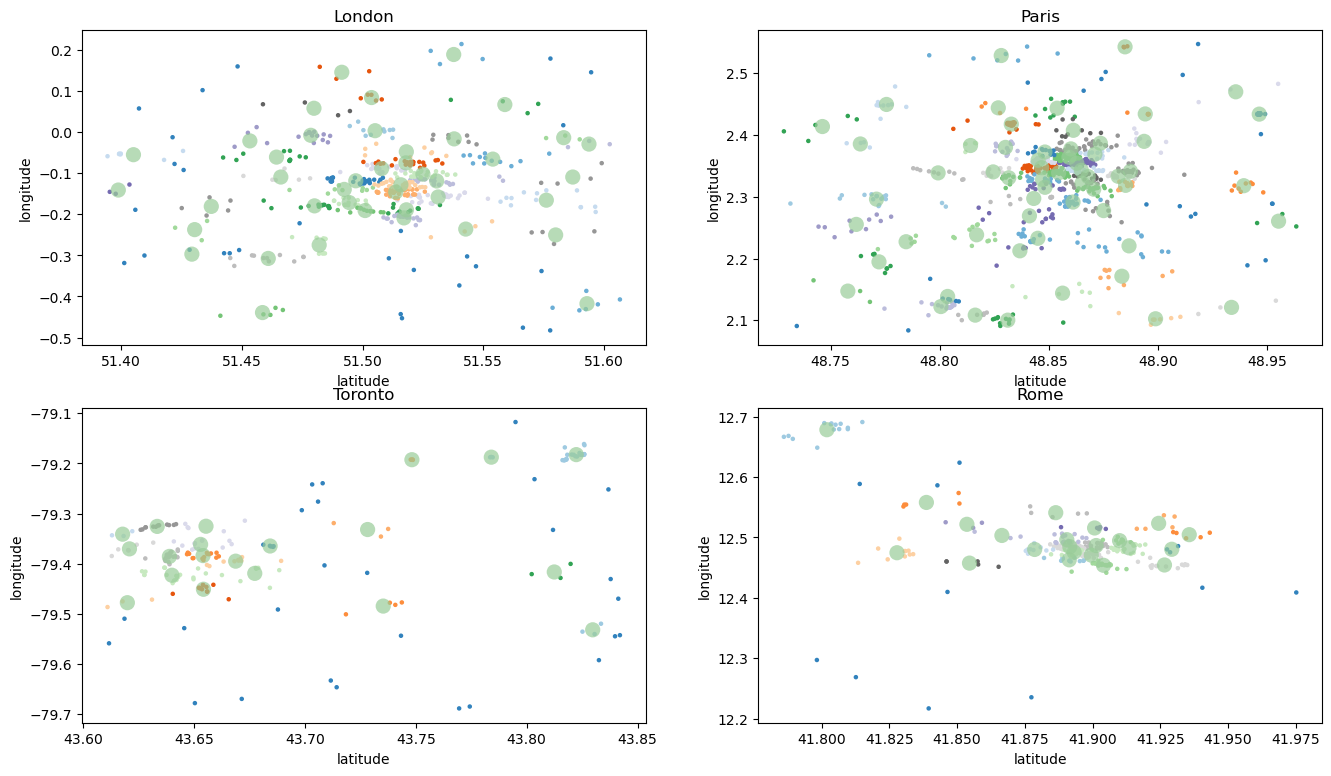

In [232]:
# plot the final round DBSCAN+KMeans cluster result, different cluster used different color as dots on map
# cluster center displays as green sphere
fig, axs = plt.subplots(2, 2, figsize=[16, 9])
axs[0, 0].scatter(final_clustered_data_pd1["lat"], final_clustered_data_pd1["lon"], c=final_clustered_data_pd1["new_cluster_id"], cmap='tab20c', s=5)
axs[0, 0].scatter(center_data_pd1["lat"], center_data_pd1["lon"], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
axs[0, 0].set_title('London')
axs[0, 1].scatter(final_clustered_data_pd2["lat"], final_clustered_data_pd2["lon"], c=final_clustered_data_pd2["new_cluster_id"], cmap='tab20c', s=5)
axs[0, 1].scatter(center_data_pd2["lat"], center_data_pd2["lon"], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
axs[0, 1].set_title('Paris')
axs[1, 0].scatter(final_clustered_data_pd3["lat"], final_clustered_data_pd3["lon"], c=final_clustered_data_pd3["new_cluster_id"], cmap='tab20c', s=5)
axs[1, 0].scatter(center_data_pd3["lat"], center_data_pd3["lon"], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
axs[1, 0].set_title('Toronto')
axs[1, 1].scatter(final_clustered_data_pd4["lat"], final_clustered_data_pd4["lon"], c=final_clustered_data_pd4["new_cluster_id"], cmap='tab20c', s=5)
axs[1, 1].scatter(center_data_pd4["lat"], center_data_pd4["lon"], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
axs[1, 1].set_title('Rome')

for ax in axs.flat:
    ax.set(xlabel='latitude', ylabel='longitude')

plt.show()

In [233]:
# Write the df into parquet for calculating travel scores
result_df_center.write.mode("overwrite").parquet("/combined_cluster_centers")